# Load package

In [129]:
import pandas as pd
import numpy as np
import datetime
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline 
from random import sample

# Load data
## Load data from database

In [2]:
path = '../data/'
conn = sqlite3.connect(path + 'trip_data.db')

In [3]:
q_license = """
SELECT distinct(hack_license) as UNIQ_LIC
FROM trip
"""

unique_license = pd.read_sql(q_license, conn)

In [4]:
LIC_SAMPLE_NUM = 5000
sampled_drivers = sample(unique_license.UNIQ_LIC.tolist(), LIC_SAMPLE_NUM)

In [5]:
# find the pickup and dropoff time of next trip
q_sample = """
SELECT *, 
        lag(pickup_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as pickup_datetime_next,
        lag(dropoff_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as dropoff_datetime_next
    FROM trip
    WHERE hack_license in {0}
ORDER BY hack_license ASC, pickup_datetime ASC, dropoff_datetime ASC
"""

sampled_trip = pd.read_sql(q_sample.format(tuple(sampled_drivers)), conn)

In [6]:
conn.close()

In [7]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,360,0.97,-73.992531,40.724052,-73.983841,40.731033,2013-06-24 19:12:00,2013-06-24 19:30:00
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,1080,3.04,-73.982498,40.745617,-73.982628,40.777344,2013-06-24 19:45:00,2013-06-24 20:10:00
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,1500,4.17,-73.981850,40.768753,-73.987068,40.726727,2013-06-24 20:17:00,2013-06-24 20:28:00
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,660,2.35,-73.988129,40.738098,-73.965042,40.761581,2013-06-24 20:30:00,2013-06-24 20:35:00
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,300,1.24,-73.961098,40.760826,-73.956833,40.774902,2013-06-24 20:37:00,2013-06-24 20:49:00


In [8]:
# convert time columns from string to datetime
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])

In [9]:
trip_fare = pd.read_csv(path + 'trip_fare_6.csv')
trip_fare.columns = trip_fare.columns.str.replace(' ','')
trip_fare.loc[:,'pickup_datetime'] = pd.to_datetime(trip_fare['pickup_datetime'])
trip_fare.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013009441,2013013593,VTS,2013-06-01,CSH,5.0,0.5,0.5,0.0,0.0,6.0
1,2013012081,2013019632,VTS,2013-06-01,CRD,14.5,0.5,0.5,1.5,0.0,17.0
2,2013006133,2013029678,VTS,2013-06-01,CSH,9.5,0.5,0.5,0.0,0.0,10.5
3,2013007864,2013007860,VTS,2013-06-01,CRD,8.0,0.5,0.5,1.7,0.0,10.7
4,2013010123,2013010123,VTS,2013-06-01,CSH,19.5,0.5,0.5,0.0,0.0,20.5


In [10]:
sampled_trip = sampled_trip.merge(trip_fare.drop(['vendor_id'], axis=1), on =['medallion','hack_license','pickup_datetime'])
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,360,0.97,-73.992531,...,40.731033,2013-06-24 19:12:00,2013-06-24 19:30:00,CSH,6.0,1.0,0.5,0.0,0.0,7.5
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,1080,3.04,-73.982498,...,40.777344,2013-06-24 19:45:00,2013-06-24 20:10:00,CRD,14.5,1.0,0.5,0.0,0.0,16.0
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,1500,4.17,-73.981850,...,40.726727,2013-06-24 20:17:00,2013-06-24 20:28:00,CRD,17.5,1.0,0.5,3.7,0.0,22.7
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,660,2.35,-73.988129,...,40.761581,2013-06-24 20:30:00,2013-06-24 20:35:00,CRD,10.5,0.5,0.5,2.2,0.0,13.7
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,300,1.24,-73.961098,...,40.774902,2013-06-24 20:37:00,2013-06-24 20:49:00,CSH,6.0,0.5,0.5,0.0,0.0,7.0


In [11]:
# save
sampled_trip.to_csv(path + 'sampled_trip.csv', index=False)
print('Saved sample_trip.csv!')

Saved sample_trip.csv!


## Load sample data

In [164]:
path = '../data/'
sampled_trip = pd.read_csv(path + 'sampled_trip.csv')
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,360,0.97,-73.992531,...,40.731033,2013-06-24 19:12:00,2013-06-24 19:30:00,CSH,6.0,1.0,0.5,0.0,0.0,7.5
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,1080,3.04,-73.982498,...,40.777344,2013-06-24 19:45:00,2013-06-24 20:10:00,CRD,14.5,1.0,0.5,0.0,0.0,16.0
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,1500,4.17,-73.981850,...,40.726727,2013-06-24 20:17:00,2013-06-24 20:28:00,CRD,17.5,1.0,0.5,3.7,0.0,22.7
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,660,2.35,-73.988129,...,40.761581,2013-06-24 20:30:00,2013-06-24 20:35:00,CRD,10.5,0.5,0.5,2.2,0.0,13.7
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,300,1.24,-73.961098,...,40.774902,2013-06-24 20:37:00,2013-06-24 20:49:00,CSH,6.0,0.5,0.5,0.0,0.0,7.0


In [165]:
# convert time columns from string to datetime
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])

----

# EDA
## Trip time
- Over 99% trips are within 20 mins 
- Less than 1% trips are less than 1 minute or over 3 hous. For trips longer than 3 hours, the distance travelled does not need that long time. Consider they are mistake record
- Less than 1% trips have `dropoff_time` < `pickup_time` (drop-off time ealier than pick-up time)
- Half of `dropoff_time` - `pickup_time` does not euqal to `trip_time_in_secs`, but over 99% of the difference are within 30 seconds

**Cleaning**
- Calculate `trip_time` = `dropoff_time` - `pickup_time`
- Drop trips that have at least one of the following values:
    - `dropoff_time` < `pickup_time` 
    - Trips that last less than 1 minute
    - Trips that last over 3 hours

In [166]:
N = sampled_trip.shape[0]
n0 = sum((sampled_trip['dropoff_datetime'] <= sampled_trip['pickup_datetime']))
n1 = sum((sampled_trip['dropoff_datetime'] - 
          sampled_trip['pickup_datetime']).dt.total_seconds() != sampled_trip['trip_time_in_secs'])

n2 = sum(abs((sampled_trip['dropoff_datetime'] - 
              sampled_trip['pickup_datetime']).dt.total_seconds() - sampled_trip['trip_time_in_secs'])>30)

n3 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) < pd.Timedelta(minutes=1))
n4 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) > pd.Timedelta(minutes=20))
n5 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) > pd.Timedelta(minutes=180))

print('{n0} ({n0_per:.2f}%) records: drop-off time before pick-up time\n\
{n1} ({n1_per:.2f}%) records: drop-off time - pick-up time != trip_time_in_secs\n\
{n2} ({n2_per:.2f}%) records: the difference > 30s\n\
{n3} ({n3_per:.2f}%) records: trip time less than 1 minutes\n\
{n4} ({n3_per:.2f}%) records: trip time over 20 minutes\n\
{n5} ({n5_per:.2f}%) records: trip time over 180 minutes\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                 n1 = n1, n1_per = n1/N*100,
                                                                 n2 = n2, n2_per = n2/N*100,
                                                                 n3 = n3, n3_per = n3/N*100,
                                                                 n4 = n4, n4_per = n4/N*100,
                                                                 n5 = n5, n5_per = n5/N*100))
print((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']).describe())

8312 (0.39%) records: drop-off time before pick-up time
934339 (43.79%) records: drop-off time - pick-up time != trip_time_in_secs
21474 (1.01%) records: the difference > 30s
15773 (0.74%) records: trip time less than 1 minutes
357096 (0.74%) records: trip time over 20 minutes
15 (0.00%) records: trip time over 180 minutes
count                   2133439
mean     0 days 00:13:01.457278
std      0 days 00:10:06.931332
min           -1 days +19:07:19
25%             0 days 00:06:19
50%             0 days 00:10:36
75%             0 days 00:17:00
max             1 days 09:29:44
dtype: object


In [167]:
sampled_trip.loc[:,'trip_time'] = (sampled_trip['dropoff_datetime'] - 
                                   sampled_trip['pickup_datetime']) / pd.Timedelta(minutes=1)
sampled_trip.loc[(sampled_trip['trip_time']>180), :]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_time
553947,2013008487,2013008483,CMT,2,2013-06-16 16:34:18,2013-06-16 19:35:46,1,1882,27.8,-73.938553,...,2013-06-16 19:40:07,2013-06-16 20:22:25,CSH,52.0,0.0,0.5,0.00,5.33,57.83,181.466667
596539,2013009263,2013009260,CMT,1,2013-06-06 01:51:36,2013-06-06 05:04:56,1,3323,4.0,-73.990242,...,2013-06-07 19:10:32,2013-06-07 19:24:14,CSH,2.5,0.5,0.5,0.00,0.00,3.50,193.333333
1074352,2013005733,2013016849,CMT,1,2013-06-18 06:12:20,2013-06-18 13:28:47,2,650,14.7,-73.782135,...,2013-06-19 05:46:17,2013-06-19 06:08:57,CSH,2.5,0.0,0.5,0.00,0.00,3.00,436.450000
1202425,2013005304,2013019001,CMT,1,2013-06-17 10:29:31,2013-06-18 19:59:15,1,650,5.3,-73.825966,...,2013-06-19 10:43:02,2013-06-19 11:16:21,NOC,21.0,0.0,0.5,0.00,0.00,21.50,2009.733333
1225519,2013012056,2013019476,CMT,2,2013-06-04 17:30:05,2013-06-05 06:29:49,3,3589,16.8,-73.789291,...,2013-06-05 06:31:46,2013-06-05 06:49:00,CSH,52.0,0.0,0.5,0.00,5.33,57.83,779.733333
1225529,2013012056,2013019476,CMT,1,2013-06-05 17:59:38,2013-06-06 06:20:43,1,1273,7.2,-73.783493,...,2013-06-06 02:37:32,2013-06-06 02:57:36,CSH,23.0,0.5,0.5,0.00,0.00,24.00,741.083333
1225564,2013012056,2013019476,CMT,1,2013-06-09 15:50:39,2013-06-10 04:40:14,1,2986,18.5,-73.782074,...,2013-06-10 05:48:52,2013-06-10 06:33:02,CSH,54.0,0.5,0.5,0.00,5.33,60.33,769.583333
1225594,2013012056,2013019476,CMT,2,2013-06-12 14:35:12,2013-06-13 03:20:46,1,2748,15.3,-73.801010,...,2013-06-12 20:22:53,2013-06-13 08:57:14,CSH,52.0,0.0,0.5,0.00,5.33,57.83,765.566667
1225595,2013012056,2013019476,CMT,2,2013-06-12 20:22:53,2013-06-13 08:57:14,1,2075,17.5,-73.796257,...,2013-06-13 03:22:26,2013-06-13 03:44:15,CRD,52.0,0.0,0.5,14.45,5.33,72.28,754.350000
1225632,2013012056,2013019476,CMT,1,2013-06-14 13:32:24,2013-06-15 01:52:24,1,1218,7.7,-73.789772,...,2013-06-17 04:01:22,2013-06-17 05:08:15,CSH,25.0,0.5,0.5,0.00,0.00,26.00,740.000000


In [168]:
index_time = (sampled_trip['trip_time']>1) & (sampled_trip['trip_time']<=180)

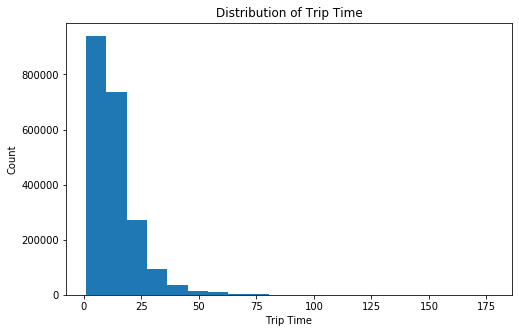

In [169]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_time, 'trip_time'].hist(bins=20, grid=False);
plt.xlabel('Trip Time');
plt.ylabel('Count');
plt.title('Distribution of Trip Time');

## Trip distance
- Over 75% trips are within 4 miles
- Less than 1% trips are longer than 30 miles
- Over 75% trips have average speed of about 15 mph

**Cleaning**
- Calculate `ave_speed` = `trip_distance` / `trip_time` * 60
- Drop trips that have at least one of the following values:
    - Speed over 50 mph ([highest speed limit in New York](https://www1.nyc.gov/html/dot/downloads/pdf/current-pre-vision-zero-speed-limit-maps.pdf))
    - Trips that longer than 30 miles ([The Manhattan Island](https://www.nycgo.com/plan-your-trip/basic-information/) is roughly 13.4 miles long and about 2.3 miles wide)

In [170]:
N = sampled_trip.shape[0]
n0 = len(sampled_trip.loc[(sampled_trip['trip_distance']<10), 'trip_distance'])
n1 = len(sampled_trip.loc[(sampled_trip['trip_distance']>30), 'trip_distance'])
n2 = len(sampled_trip.loc[(sampled_trip['trip_distance']<=0), 'trip_distance'])
print('{n0} ({n0_per:.2f}%) records: trip distance within 10 mile\n\
{n1} ({n1_per:.2f}%) records: trip distance are over 30 mile\n\
{n2} ({n2_per:.2f}%) records: trip distance <= 0 mile\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                             n1 = n1, n1_per = n1/N*100,
                                                             n2 = n2, n2_per = n2/N*100))
print(sampled_trip['trip_distance'].describe())
print('=========================================================\nAverage speed')
print((sampled_trip['trip_distance'] / sampled_trip['trip_time'] * 60).describe())

2027074 (95.01%) records: trip distance within 10 mile
506 (0.02%) records: trip distance are over 30 mile
11775 (0.55%) records: trip distance <= 0 mile
count    2.133439e+06
mean     2.939555e+00
std      3.403654e+00
min      0.000000e+00
25%      1.090000e+00
50%      1.800000e+00
75%      3.300000e+00
max      1.000000e+02
Name: trip_distance, dtype: float64
Average speed
count    2.129435e+06
mean              inf
std               NaN
min     -3.960000e+03
25%      8.347826e+00
50%      1.155000e+01
75%      1.576364e+01
max               inf
dtype: float64


In [171]:
index_distance = (((sampled_trip['trip_distance']/sampled_trip['trip_time']*60)<50) & 
                  (sampled_trip['trip_distance']<30) & 
                  (sampled_trip['trip_distance']>0))

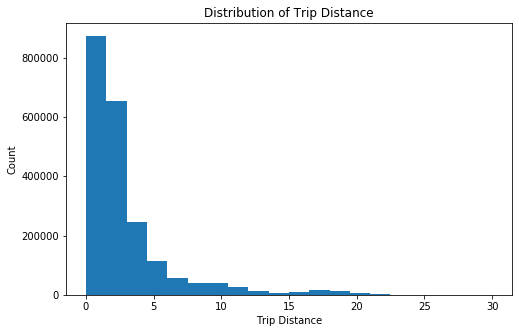

In [172]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_distance, 'trip_distance'].hist(bins=20, grid=False);
plt.xlabel('Trip Distance');
plt.ylabel('Count');
plt.title('Distribution of Trip Distance');

## Trip fare
- Over 99% trips have fare more than \\$2.5 and less than \\$150
- 82% trips have fare less then \\$20

**Cleaning**
- Drop trips that have trip fare over \\$150 (\\$2.5 * 60 miles)

In [173]:
N = sampled_trip.shape[0]
n0 = len(sampled_trip.loc[(sampled_trip['total_amount']<=2.5), 'total_amount'])
n1 = len(sampled_trip.loc[(sampled_trip['total_amount']<=20), 'total_amount'])
n2 = len(sampled_trip.loc[(sampled_trip['total_amount']<150), 'total_amount'])
print('{n0} ({n0_per:.2f}%) records: trip fare < $2.5\n\
{n1} ({n1_per:.2f}%) records: trip fare < $20\n\
{n2} ({n2_per:.2f}%) records: trip fare < $150\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                  n1 = n1, n1_per = n1/N*100,
                                                                  n2 = n2, n2_per = n2/N*100))
print(sampled_trip['total_amount'].describe())

1 (0.00%) records: trip fare < $2.5
1759725 (82.48%) records: trip fare < $20
2132979 (99.98%) records: trip fare < $150
count    2.133439e+06
mean     1.504341e+01
std      1.228333e+01
min      2.500000e+00
25%      8.000000e+00
50%      1.140000e+01
75%      1.700000e+01
max      5.643900e+02
Name: total_amount, dtype: float64


In [174]:
index_fare = sampled_trip['total_amount']<150

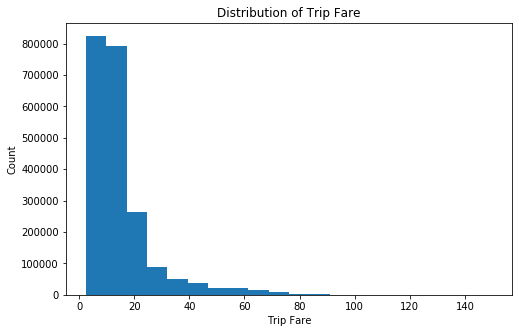

In [175]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_fare, 'total_amount'].hist(bins=20, grid=False);
plt.xlabel('Trip Fare');
plt.ylabel('Count');
plt.title('Distribution of Trip Fare');

# Pick-up and drop-off location
- Over 98% trips' pick-up and drop-off locations are within NYC

**Cleaning**
- Drop trips with pick-up or drop-off location outside of NYC

In [176]:
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon

In [177]:
# download map here: https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-Map/5fzm-kpwv
nyc_map = pd.read_csv(path + '../data/Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv')
nyc_map['geometry'] = nyc_map['the_geom'].apply(wkt.loads)
nyc_map = gpd.GeoDataFrame(nyc_map, crs='EPSG:4326').drop('the_geom', axis=1)

# download map here: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq
# nyc_map = gpd.read_file(path + '../Neighborhood Tabulation Areas (NTA).geojson')

# download map here: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
# nyc_map = gpd.read_file(path + '../ZIP_CODE_040114/ZIP_CODE_040114.shp')

# download map here: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
# nyc_map = gpd.read_file(path +'../Borough_Boundaries/geo_export_573e53b9-f38f-46eb-be8d-0f07d0d0e9d1.shp')
nyc_map.head()

,MODZCTA,label,ZCTA,pop_est,geometry
0,10001,"10001, 10118","10001, 10119, 10199",23072,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ..."
1,10002,10002,10002,74993,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ..."
2,10003,10003,10003,54682,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ..."
3,10004,10004,10004,3028,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ..."
4,10005,10005,"10005, 10271",8831,"MULTIPOLYGON (((-74.00783 40.70309, -74.00786 ..."


In [178]:
# drop gps records (roughly) outside of nyc 
nyc_loc = [-74.25,-73.75, 40.45, 40.95]
index_location = (sampled_trip['pickup_longitude'] > nyc_loc[0]) &   \
                    (sampled_trip['pickup_longitude'] < nyc_loc[1]) & \
                    (sampled_trip['pickup_latitude'] > nyc_loc[2]) & \
                    (sampled_trip['pickup_latitude'] < nyc_loc[3]) & \
                    (sampled_trip['dropoff_longitude'] > nyc_loc[0]) & \
                    (sampled_trip['dropoff_longitude'] < nyc_loc[1]) & \
                    (sampled_trip['dropoff_latitude'] > nyc_loc[2]) & \
                    (sampled_trip['dropoff_latitude'] < nyc_loc[3])


N = sampled_trip.shape[0]
n0 = sum(index_location)
print('{n0} ({n0_per:.2f}%) are roughly in NYC'.format(n0=n0, n0_per=n0/N*100))

2091821 (98.05%) are roughly in NYC


In [181]:
# location_index = sampled_trip.index.tolist()
features = ['hack_license','trip_distance',
            'pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude']

sample_n = 5000
sample_index = sample(index_location[index_location==True].index.tolist(), sample_n)

# convert the first pickup location to geometric form
pickup_location = gpd.GeoDataFrame(sampled_trip.loc[sample_index, features], 
                                   geometry = gpd.points_from_xy(pickup_location['pickup_longitude'],
                                                                 pickup_location['pickup_latitude']))

# convert the last dropoff location to geometric form
dropoff_location = gpd.GeoDataFrame(sampled_trip.loc[sample_index, features], 
                                    geometry = gpd.points_from_xy(dropoff_location['dropoff_longitude'],
                                                                  dropoff_location['dropoff_latitude'])).reindex(columns=col_index)

pickup_location.head()

,hack_license,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,geometry
1889094,2013032675,1.19,-73.996567,40.742882,-74.005966,40.753380,POINT (-73.98164 40.78396)
652078,2013010233,2.71,-73.988808,40.722061,-74.002731,40.747944,POINT (-74.00769 40.75158)
276505,2013004260,3.10,-73.990341,40.730564,-73.991821,40.764832,POINT (-73.98822 40.76157)
327700,2013005065,0.70,-73.967606,40.756264,-73.975098,40.752220,POINT (-73.78535 40.64613)
1939529,2013033698,5.40,-73.985443,40.727242,-73.924667,40.746723,POINT (-73.97581 40.75960)


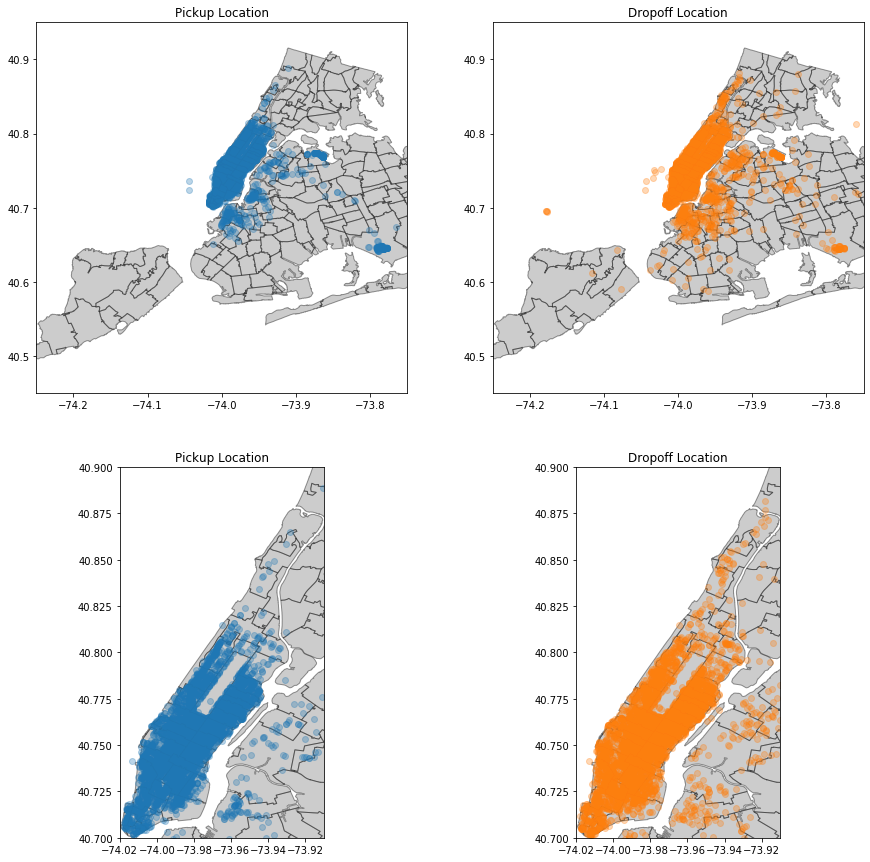

In [182]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
# add mapfile to axes
nyc_map.plot(ax=ax[0,0], alpha=0.4, edgecolor='k', color='grey');
pickup_location.plot(ax=ax[0,0], color='tab:blue', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[0,0].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[0,0].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[0,0].set_title('Pickup Location');

# add mapfile to axes
nyc_map.plot(ax=ax[0,1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location.plot(ax=ax[0,1], color='tab:orange', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[0,1].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[0,1].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[0,1].set_title('Dropoff Location');

nyc_map.plot(ax=ax[1,0], alpha=0.4, edgecolor='k', color='grey');
pickup_location.plot(ax=ax[1,0], color='tab:blue', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1,0].set_xlim(-74.02,-73.91);
ax[1,0].set_ylim( 40.7,40.9);
ax[1,0].set_title('Pickup Location');

# add mapfile to axes
nyc_map.plot(ax=ax[1,1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location.plot(ax=ax[1,1], color='tab:orange', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1,1].set_xlim(-74.02,-73.91);
ax[1,1].set_ylim( 40.7,40.9);
ax[1,1].set_title('Dropoff Location');

----
## Drop outliers

In [183]:
# drop outliers
N = sampled_trip.shape[0]
n1 = sum(~(index_time & index_distance & index_fare & index_location))
print('drop {:.2f} % of data'.format(n1/N*100))
sampled_trip = sampled_trip.loc[(index_time & index_distance & index_fare & index_location), :]\
                            .drop('trip_time_in_secs', axis=1) \
                            .sort_values(['hack_license', 'pickup_datetime', 'dropoff_datetime'])
# recalculate delta
sampled_trip.loc[:, 'pickup_datetime_next'] = sampled_trip.groupby(['hack_license'])['pickup_datetime'].shift(-1)
sampled_trip.loc[:, 'dropoff_datetime_next'] = sampled_trip.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
sampled_trip.loc[:, 'delta'] = (sampled_trip['pickup_datetime_next'] - sampled_trip['dropoff_datetime']) / pd.Timedelta(hours=1)
sampled_trip.head()

drop 3.02 % of data


,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_time,delta
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,2013-06-24 19:30:00,CSH,6.0,1.0,0.5,0.0,0.0,7.5,6.0,0.183333
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,2013-06-24 20:10:00,CRD,14.5,1.0,0.5,0.0,0.0,16.0,18.0,0.250000
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,2013-06-24 20:28:00,CRD,17.5,1.0,0.5,3.7,0.0,22.7,25.0,0.116667
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,2013-06-24 20:35:00,CRD,10.5,0.5,0.5,2.2,0.0,13.7,11.0,0.033333
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,2013-06-24 20:49:00,CSH,6.0,0.5,0.5,0.0,0.0,7.0,5.0,0.033333


- k=3, 41 (0.002%) active time > 24h
- k=4, 79 (0.004%) active time > 24h
- k=5, 127 (0.006%) active time > 24h

In [221]:
k = 5

## If delta > k, the trip is the last drop off of the shift
## And the next trip of the driver is the first pickup (shifted)
sampled_trip['last_dropoff'] = [1 if d > k else 0 for d in sampled_trip['delta']]
sampled_trip['first_pickup'] = sampled_trip.groupby('hack_license')['last_dropoff'].shift(1)
sampled_trip.dropna(subset=['pickup_datetime_next', 'dropoff_datetime_next'], inplace=True) 
sampled_trip['first_pickup'].fillna(0, inplace=True)

In [222]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,6.0,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,18.0,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,25.0,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,11.0,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,5.0,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1


In [223]:
## Extract hour and day
sampled_trip['dropoff_time'] = sampled_trip.dropoff_datetime.dt.round('15min').dt.time
sampled_trip['pickup_time'] = sampled_trip.pickup_datetime.dt.round('15min').dt.time
# sampled_trip['dropoff_time'] = sampled_trip.dropoff_datetime.dt.round('15min').dt.hour + \
#                                 sampled_trip.dropoff_datetime.dt.round('15min').dt.minute / 60
# sampled_trip['pickup_time'] = sampled_trip.pickup_datetime.dt.round('15min').dt.hour + \
#                                 sampled_trip.pickup_datetime.dt.round('15min').dt.minute / 60
sampled_trip['dropoff_day'] = sampled_trip.dropoff_datetime.dt.date
sampled_trip['pickup_day'] = sampled_trip.pickup_datetime.dt.date
sampled_trip['pickup_weekday'] = (sampled_trip.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 0).astype(int)
sampled_trip['dropoff_weekday'] = (sampled_trip.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 0).astype(int)


In [224]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,6.0,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,18.0,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,25.0,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,11.0,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,5.0,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1


## First pick-up and last drop-off distribution
- Two peaks of pick-up time: 6:00 am, 5:00 pm
- Two peaks of drop-off time: 1:00 am, 4:00 pm
- The pick-up peak on weekend morning appears later: 7:00 am
- The drop-off peak on weekend midnight appears later: 4:00 am

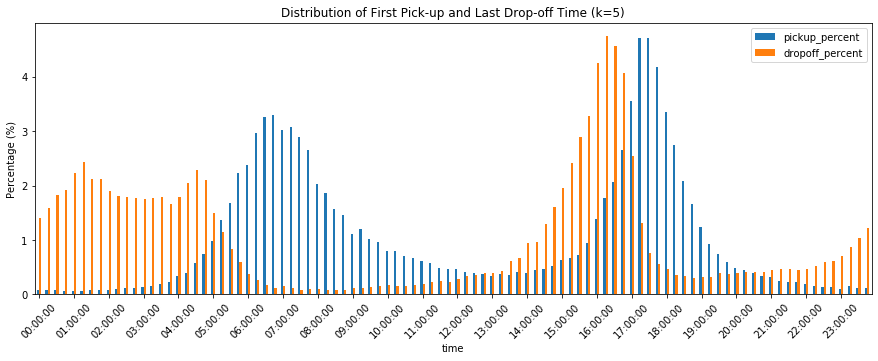

In [225]:
## Compute percentage
ticks = sorted(sampled_trip['pickup_time'].unique())

pickup_df = sampled_trip.loc[sampled_trip['first_pickup'] == 1]
pickup_per = pickup_df.groupby(['pickup_day', 'pickup_time', 'pickup_weekday'])['pickup_time'].count()
pickup_per = pd.DataFrame(pickup_per).rename(columns={'pickup_time':'pickup_percent'}).reset_index().\
                                        rename(columns={'pickup_day':'date',
                                                        'pickup_time':'time',
                                                           'pickup_weekday': 'weekday'})

dropoff_df = sampled_trip.loc[sampled_trip['last_dropoff'] == 1]
dropoff_per = dropoff_df.groupby(['dropoff_day', 'dropoff_time', 'dropoff_weekday'])['dropoff_time'].count()
# dropoff_per = dropoff_per.groupby('dropoff_day').apply(lambda x: x / x.sum() * 100)
dropoff_per = pd.DataFrame(dropoff_per).rename(columns={'dropoff_time':'dropoff_percent'}).reset_index().\
                                        rename(columns={'dropoff_day':'date',
                                                        'dropoff_time':'time',
                                                           'dropoff_weekday': 'weekday'})

pick_drop_per = pickup_per.merge(dropoff_per)
pick_drop_per.head()


# % of Pick-up and Drop-off Time
# pick_drop_per_all = pick_drop_per.groupby(['time'])['pickup_percent','dropoff_percent'].mean().\
#                                 reset_index().set_index('time')
pick_drop_per_all = pick_drop_per.groupby(['time'])['pickup_percent','dropoff_percent'].mean()
pick_drop_per_all[['pickup_percent','dropoff_percent']] /= pick_drop_per_all[['pickup_percent','dropoff_percent']].sum() / 100

fig,ax = plt.subplots(figsize = (15,5))
pick_drop_per_all.plot(kind='bar',ax=ax);
ax.set_xlabel('time');
ax.set_ylabel('Percentage (%)');
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticks(xticks[::4]);
ax.set_xticklabels(xticklabels[::4], rotation=45);
ax.set_title('Distribution of First Pick-up and Last Drop-off Time (k={})'.format(k));
ax.legend();
# fig.savefig(path + '../img/pick_drop_time(k_{}).png'.format(k));

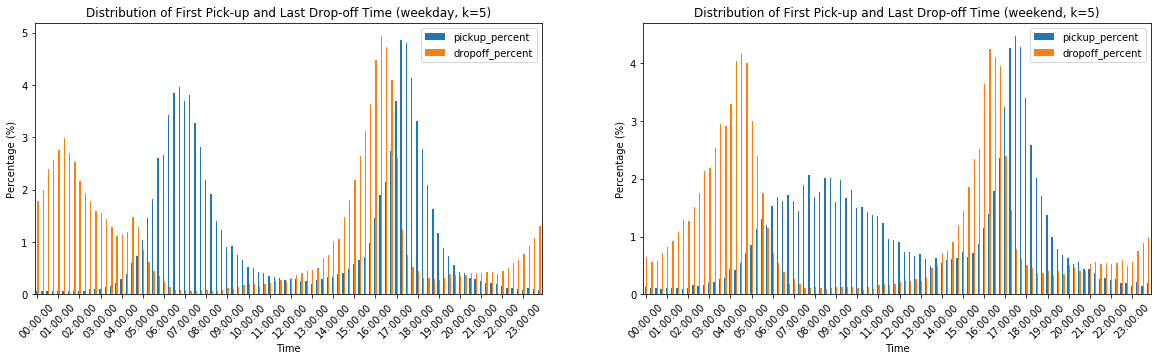

In [226]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
# pick_drop_per_wk = pick_drop_per.groupby(['time','weekday'])['pickup_percent','dropoff_percent'].mean().\
#                                 reset_index().set_index('time')
pick_drop_per_wk = pick_drop_per.groupby(['time','weekday'])['pickup_percent','dropoff_percent'].mean()
pick_drop_per_wk[['pickup_percent','dropoff_percent']] /= pick_drop_per_wk[['pickup_percent',
                                                                            'dropoff_percent']].groupby(level=1).sum() / 100
pick_drop_per_wk = pick_drop_per_wk.reset_index().set_index('time')

fig,ax = plt.subplots(1,2,figsize = (20,5))
pick_drop_per_wk[pick_drop_per_wk.weekday == 1].drop('weekday',axis=1).plot(kind='bar',ax=ax[0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 0].drop('weekday',axis=1).plot(kind='bar',ax=ax[1]);
xticks = ax[0].get_xticks()
xticklabels = ax[0].get_xticklabels()
ax[0].set_xticks(xticks[::4]);
ax[0].set_xticklabels(xticklabels[::4], rotation=45);
ax[0].set_xlabel('Time');
ax[0].set_ylabel('Percentage (%)');
ax[0].set_title('Distribution of First Pick-up and Last Drop-off Time (weekday, k={})'.format(k));
ax[0].legend();

xticks = ax[1].get_xticks()
xticklabels = ax[1].get_xticklabels()
ax[1].set_xticks(xticks[::4]);
ax[1].set_xticklabels(xticklabels[::4], rotation=45);
ax[1].set_xlabel('Time');
ax[1].set_ylabel('Percentage (%)');
ax[1].set_title('Distribution of First Pick-up and Last Drop-off Time (weekend, k={})'.format(k));
ax[1].legend();
# fig.savefig(path + '../img/pick_drop_time_wk(k_{}).png'.format(k));

# Active time
- Over 75% shifts are within 10 hours; most of the shift are 8 to 10 hours
- Less than 1% shifts are over 24 hours.This depends on the choice of threshold `k`
- Less than 1% shifts are less than 1 hours. Some drivers would work a few trips during rest time

**Cleaning**
- Drop data that have active time less than 1 hour or over 24 hours

In [227]:
# compute active time 
# Active time = end time of the shift - start time of the shift
active_time = sampled_trip.loc[sampled_trip['last_dropoff'] == 1,
                               ['hack_license', 'dropoff_datetime','pickup_datetime_next']].\
                        rename(columns={'pickup_datetime_next':'start_datetime'}).\
                        sort_values(['hack_license','start_datetime'])

active_time['end_datetime'] = active_time.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
active_time['active_hour'] = (active_time['end_datetime'] - active_time['start_datetime']) / pd.Timedelta(hours=1)
active_time = active_time.drop(['dropoff_datetime'], axis=1).dropna()
active_time.head()

,hack_license,start_datetime,end_datetime,active_hour
7,2013000001,2013-06-26 17:24:00,2013-06-27 00:44:00,7.333333
26,2013000001,2013-06-27 17:20:00,2013-06-28 01:26:00,8.100000
56,2013000001,2013-06-28 18:08:00,2013-06-29 02:58:00,8.833333
85,2013000001,2013-06-29 18:07:00,2013-06-30 04:49:00,10.700000
145,2013000008,2013-06-02 12:40:00,2013-06-02 22:35:00,9.916667


In [228]:
# drop incorrect record 
N = sampled_trip.shape[0]
n0 = active_time[(active_time.active_hour<1)].shape[0]
n1 = active_time[(active_time.active_hour>=24)].shape[0]
print('{n0} ({n0_per:.3f}%) records: active time < 1 hour\n\
{n1} ({n1_per:.3f}%) records: active time > 24 hours\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                             n1 = n1, n1_per = n1/N*100))
print(active_time.active_hour.describe())

1170 (0.057%) records: active time < 1 hour
127 (0.006%) records: active time > 24 hours
count    89696.000000
mean         8.699501
std          3.105255
min          0.018333
25%          7.283333
50%          8.866667
75%         10.223403
max        115.151111
Name: active_hour, dtype: float64


In [229]:
index_active_hour = (active_time.active_hour>1) & (active_time.active_hour<24)

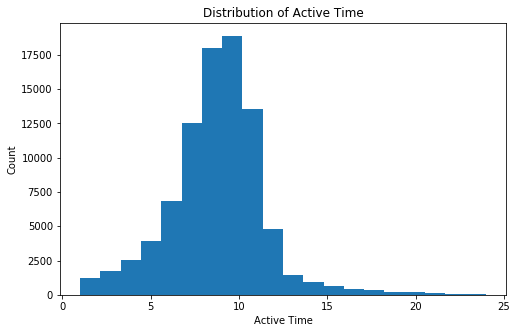

In [230]:
plt.figure(figsize=(8,5))
active_time.loc[index_active_hour, 'active_hour'].hist(bins=20, grid=False);
plt.xlabel('Active Time');
plt.ylabel('Count');
plt.title('Distribution of Active Time');
# fig.savefig(path + '../img/active_time(k_{}).png'.format(k));

# Active Time Estimation

* active time = last drop-off time - first pick-up time
* There are 2 shifts in a day. We define shift A and shift B. Early pickups are associated with later dropoffs and later pickups are associated with early dropoffs.

  ![Caption for the picture.](../fig/shift_range.png)
  
* The decision on the time ranges are based on the distributions presented above.
* There are about the same proportion of drivers in each shift.
* To simulate an active time of a driver, we
    1. randomly pick shift with 1/2 chance being in shift A (equally proportionated)
    2. randomly pick the first PU time from all PU times in the chosen shift
    3. randomly pick the last DO time from all DO times in the chosen shift (must be later than the chosen first PU time)

In [198]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,6.0,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,18.0,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,25.0,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,11.0,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,5.0,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1


There is a caveat in the current code. It is possible 

In [199]:
def get_shift(time, weekday=True, pickup=True):
    if weekday:
        if pickup:
            if (time > datetime.time(23, 30)) | (time <= datetime.time(11, 30)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(8, 30)) & (time <= datetime.time(20, 30)):
                return 'A'
            else:
                return 'B'            
    else: ## weekend
        if pickup:
            if (time > datetime.time(2, 0)) & (time <= datetime.time(14, 0)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(10, 0)) & (time <= datetime.time(22, 0)):
                return 'A'
            else:
                return 'B'        
        return None
    
def sample_start_end_time(first_last_trip_df, shift_prop, weekday_code):
    random_shift = np.random.choice(['A', 'B'], size=1, 
                                    p = shift_prop.loc[(shift_prop['pickup_weekday'] == weekday_code)][0].tolist())[0]
    # travel_time = datetime.timedelta(minutes=10)
#     print("random_shift: {}".format(random_shift))
    sampled_PU_time = first_last_trip_df.loc[(first_last_trip_df['_PU_shift'] == random_shift) &
                                            (first_last_trip_df['first_pickup'] == 1)]['PU_time'].sample().values[0]

    if random_shift == 'A':
        try:
            sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
#         print("-", sampled_DO_time)#
        except:
            print(random_shift)
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)].shape)
            return None, None
    else: #shift B dropoff
        try:
            sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                ((first_last_trip_df['DO_time'] > sampled_PU_time) |
                                                 (first_last_trip_df['DO_time'] <= datetime.time(8,30)))  &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
        except:
            
            print(random_shift)
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)].shape)
            return None, None
            #         print("-", sampled_DO_time) #.sample().values[0])
#     print("--Sampled PU time>> {}".format(sampled_PU_time))
#     print("--Sampled DO time>> {}".format(sampled_DO_time))
    
    return sampled_PU_time, sampled_DO_time



In [200]:
first_last_trip = sampled_trip.loc[(sampled_trip['first_pickup'] == 1) |
                                     (sampled_trip['last_dropoff'] == 1)]

first_last_trip.loc[:,'PU_time'] = first_last_trip['pickup_datetime'].apply(lambda x: x.time())
first_last_trip.loc[:,'DO_time'] = first_last_trip['dropoff_datetime'].apply(lambda x: x.time())


## determine shift for weekdays
first_last_trip.loc[(first_last_trip['pickup_weekday']==1) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=True))
first_last_trip.loc[(first_last_trip['dropoff_weekday']==1) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=False))

## determine shift for weekends
first_last_trip.loc[(first_last_trip['pickup_weekday']==0) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=True))
first_last_trip.loc[(first_last_trip['dropoff_weekday']==0) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=False))

D:\Ananconda\install\envs\py3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Ananconda\install\envs\py3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [201]:
proportion_table = first_last_trip.loc[first_last_trip['first_pickup'] == 1].groupby(['pickup_weekday', '_PU_shift']).size()\
                .groupby(['pickup_weekday']).apply(lambda x: x/x.sum()).reset_index()
proportion_table

,pickup_weekday,_PU_shift,0
0,0,A,0.514759
1,0,B,0.485241
2,1,A,0.501591
3,1,B,0.498409


## Simulate weekend active hours

In [202]:
def find_time_diff(original_do_time, original_pu_time):
    
    pu_time = datetime.datetime.combine(datetime.datetime(2020, 1,1), original_pu_time)
    if original_do_time < original_pu_time:
        do_time = datetime.datetime.combine(datetime.datetime(2020, 1,2), original_do_time)
    else:
        do_time = datetime.datetime.combine(datetime.datetime(2020, 1,1), original_do_time)
        
#     print(pu_time)
#     print(do_time)
    return (do_time - pu_time).total_seconds() / 3600
#     datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), d_list[0]) - datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), p_list[0])

In [203]:
first_last_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,PU_time,DO_time,_PU_shift,_DO_shift
7,2013000001,2013000001,VTS,1,2013-06-24 22:07:00,2013-06-24 22:13:00,2,0.82,-73.929214,40.753971,...,22:15:00,22:00:00,2013-06-24,2013-06-24,1,1,22:07:00,22:13:00,NaN,B
8,2013000001,2013000001,VTS,1,2013-06-26 17:24:00,2013-06-26 17:35:00,1,0.86,-73.971581,40.757946,...,17:30:00,17:30:00,2013-06-26,2013-06-26,1,1,17:24:00,17:35:00,B,NaN
26,2013000001,2013000001,VTS,1,2013-06-27 00:25:00,2013-06-27 00:44:00,1,4.79,-73.980392,40.721916,...,00:45:00,00:30:00,2013-06-27,2013-06-27,1,1,00:25:00,00:44:00,NaN,B
27,2013000001,2013000001,VTS,1,2013-06-27 17:20:00,2013-06-27 17:27:00,1,1.24,-73.971268,40.757866,...,17:30:00,17:15:00,2013-06-27,2013-06-27,1,1,17:20:00,17:27:00,B,NaN
56,2013000001,2013000001,VTS,1,2013-06-28 01:09:00,2013-06-28 01:26:00,2,5.87,-73.952744,40.776684,...,01:30:00,01:15:00,2013-06-28,2013-06-28,1,1,01:09:00,01:26:00,NaN,B


In [204]:
p_list = []
d_list = []
active_time = {'weekday': [], 'weekend': []}
for t in range(100):
    pu,do = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 1],
                                 proportion_table, weekday_code=1)
#     p_list.append(pu)
#     d_list.append(do)
    try:
        active_time['weekday'].append(find_time_diff(do, pu))
    except:
        print('error in sampling (weekday)')
        
    pu,do = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 0],
                                 proportion_table, weekday_code=0)
    
    try:
        active_time['weekend'].append(find_time_diff(do, pu))
    except:
        print('error in sampling (weekend)')


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].hist(active_time['weekday'])
ax[0].set_title('Histogram of Simulated Active Times on Weekday')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Counts')
ax[1].hist(active_time['weekend'])
ax[1].set_title('Histogram of Simulated Active Times on Weekend')
ax[1].set_xlabel('Hour')